# Exploratory Data Analysis of Titanic Prediction Data

#### Goal: To predict passenger survival outcome and probability.
Dataset can be downloaded from my GitHub repository: [mygitrepo](https://raw.githubusercontent.com/crosstrack10/data-science-projects/main/datasets/titanic_data.csv)

## Exploratory Analysis
Importing necessary packages and reading in the dataset.

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config Completer.use_jedi = False

In [2]:
# reading in dataset from github repository
url = "https://raw.githubusercontent.com/crosstrack10/data-science-projects/main/datasets/titanic_data.csv"
titanic_data = pd.read_csv(url)

In [3]:
# shuffling dataset
titanic_data = titanic_data.sample(frac = 1).reset_index(drop = True)

In [4]:
# first five rows
titanic_data.head()

,Row,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,809,3,0,"Ford, Mr. Arthur",male,NaN,0,0,A/5 1478,8.0500,NaN,S,"Bridgwater, Somerset, England"
1,561,2,1,"Sinkkonen, Miss. Anna",female,30.0,0,0,250648,13.0000,NaN,S,"Finland / Washington, DC"
2,438,2,1,"Herman, Miss. Alice",female,24.0,1,2,220845,65.0000,NaN,S,"Somerset / Bernardsville, NJ"
3,988,3,0,"Mahon, Miss. Bridget Delia",female,NaN,0,0,330924,7.8792,NaN,Q,NaN
4,765,3,0,"Dean, Mr. Bertram Frank",male,26.0,1,2,C.A. 2315,20.5750,NaN,S,"Devon, England Wichita, KS"


In [5]:
# general variable info
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Row        1309 non-null   int64  
 1   pclass     1309 non-null   int64  
 2   survived   1309 non-null   int64  
 3   name       1309 non-null   object 
 4   sex        1309 non-null   object 
 5   age        1046 non-null   float64
 6   sibsp      1309 non-null   int64  
 7   parch      1309 non-null   int64  
 8   ticket     1309 non-null   object 
 9   fare       1308 non-null   float64
 10  cabin      295 non-null    object 
 11  embarked   1307 non-null   object 
 12  home.dest  745 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 133.1+ KB


The pclass feature should be changed to object data type.

In [6]:
# converting column types to appropriate type
cols = ["pclass"]
titanic_data[cols] = titanic_data[cols].astype('O')

In [7]:
# counting number of nulls
null_count = titanic_data.isna().sum()
null_count[null_count > 0].sort_values(ascending = False)

cabin        1014
home.dest     564
age           263
embarked        2
fare            1
dtype: int64

The cabin and home.dest features have a lot of nulls present. They probably won't do any good as feature inputs.
Rows with null values in the age column can be dropped for now so we can perform variable relationship analysis.

In [8]:
# dropping cabin and home.dest variables (high percentage of null values)
titanic_no_nulls = titanic_data.drop(labels = ["cabin", "home.dest"], axis = 1)

In [9]:
# dropping rows with na's
titanic_no_nulls = titanic_no_nulls.dropna(axis = 0)

In [10]:
# counting number of nulls
null_count = titanic_no_nulls.isna().sum()
null_count[null_count > 0].sort_values(ascending = False)

Series([], dtype: int64)

In [11]:
# creating function to count categorical values
def count_categorical(dataset):
    for col in dataset.columns:
        if dataset[col].dtype == np.dtype('O'):
            col_count = dataset[col].value_counts()
            print(col_count, "\n")
        else:
            pass

In [12]:
# printing column names
for col in titanic_data.columns:
        print(col)

Row
pclass
survived
name
sex
age
sibsp
parch
ticket
fare
cabin
embarked
home.dest


In [13]:
# counting values by category for object data types
count_categorical(titanic_no_nulls)

3    500
1    282
2    261
Name: pclass, dtype: int64 

Connolly, Miss. Kate                                2
Kelly, Mr. James                                    2
Kenyon, Mr. Frederick R                             1
Leyson, Mr. Robert William Norman                   1
Rice, Mrs. William (Margaret Norton)                1
                                                   ..
Mayne, Mlle. Berthe Antonine ("Mrs de Villiers")    1
Bostandyeff, Mr. Guentcho                           1
Barbara, Miss. Saiide                               1
Reynaldo, Ms. Encarnacion                           1
Wittevrongel, Mr. Camille                           1
Name: name, Length: 1041, dtype: int64 

male      657
female    386
Name: sex, dtype: int64 

CA 2144         8
3101295         7
347077          7
347082          7
S.O.C. 14879    7
               ..
13049           1
5727            1
315154          1
370376          1
349207          1
Name: ticket, Length: 730, dtype: int64 

S    781
C    2

In [14]:
# retrieving general statistics for numerical variables
titanic_no_nulls.describe()

,Row,survived,age,sibsp,parch,fare
count,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000
mean,600.331735,0.407478,29.813199,0.504314,0.421860,36.603024
std,364.291510,0.491601,14.366261,0.913080,0.840655,55.753648
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000
25%,300.500000,0.000000,21.000000,0.000000,0.000000,8.050000
50%,576.000000,0.000000,28.000000,0.000000,0.000000,15.750000
75%,875.000000,1.000000,39.000000,1.000000,1.000000,35.077100
max,1309.000000,1.000000,80.000000,8.000000,6.000000,512.329200


The custom function listed below calculate will information gain based on data type class.

In [15]:
# importing scipy.stats entropy
from scipy.stats import entropy

# creating function to calculate entropy
def cal_entropy(dataset, log_base = 2.718281828459):
    entropy_dict = {}
    for vect in dataset.columns:
        if dataset[vect].dtype == np.dtype('O'):
            vect_rel_prob = dataset[vect].value_counts() / len(dataset[vect])
            vect_entropy = entropy(vect_rel_prob, base = log_base)
            entropy_dict[vect] = vect_entropy
        else:
            pass
    return(entropy_dict)

In [16]:
# creating dictionary to store results
ig_dict = cal_entropy(titanic_no_nulls, 2)

# calculating information gain and storing a dataframe
info_gain = (
    pd.DataFrame(list(ig_dict.items()), columns = ["features", "IG"]).
    sort_values(by = ["IG"], ascending = False)
)
info_gain.reset_index(inplace = True, drop = True)
info_gain

,features,IG
0,name,10.022688
1,ticket,9.283192
2,pclass,1.518825
3,embarked,0.989821
4,sex,0.950738


This first few instances might be useful. Let's see if they appear in the correlation results.

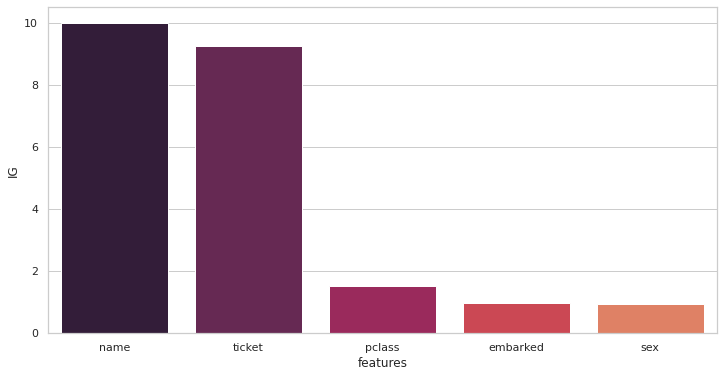

In [17]:
# visualizing information gain
plt.figure(figsize = (12,6))
sns.set_theme(style = "whitegrid")
ax = sns.barplot(x = "features", y = "IG", data = info_gain, palette = sns.color_palette("rocket"))
plt.show()

<Figure size 864x432 with 0 Axes>

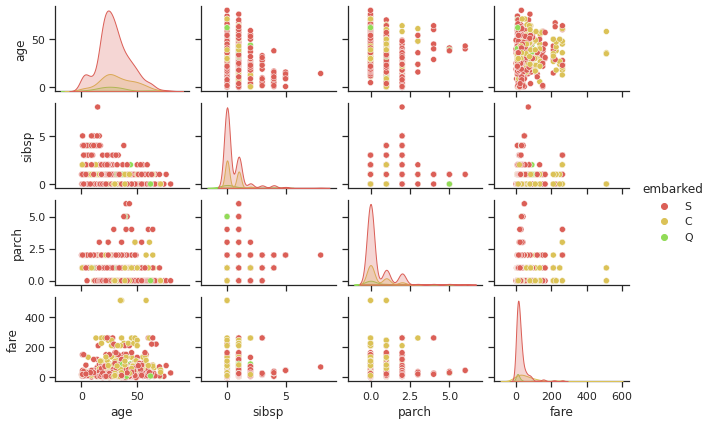

In [18]:
# numerical vairables corrleation and distributions
plt.style.use("fivethirtyeight")
plt.figure(figsize = (12,6))
sns.set_theme(style = "ticks")
sns.set_palette(sns.color_palette("hls", 8))
sns.pairplot(data = titanic_no_nulls[["age", "sibsp", "parch", "fare", "embarked"]], 
             hue = "embarked", diag_kind = "kde", height = 1.5, aspect = 1.5)
plt.show()

Most numerical distributions are negatively skewed. Correlation of "independent" variables is not obvious.

In [19]:
# converting categorical values to numerical to see relationships 
from sklearn import preprocessing

label = preprocessing.LabelEncoder()
titanic_encoded = pd.DataFrame() 

for i in titanic_no_nulls.columns :
  titanic_encoded[i] = label.fit_transform(titanic_no_nulls[i])

sex        -0.536332
pclass     -0.317737
embarked   -0.202258
ticket     -0.112899
age        -0.055155
name       -0.010417
sibsp      -0.009809
parch       0.115436
fare        0.308960
survived    1.000000
Name: survived, dtype: float64


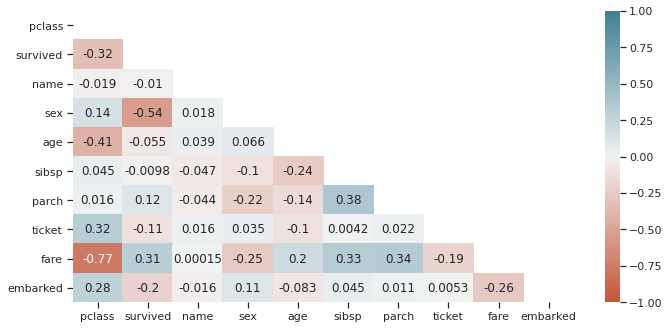

In [20]:
# Creating correlation matrix
corr_matrix = titanic_encoded.drop(axis = 1, columns = "Row").corr()
print(corr_matrix["survived"].sort_values())

# visualizing it
plt.figure(figsize = (10,5))
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, mask = mask, annot = True, vmin = -1, vmax = 1, 
            cmap = sns.diverging_palette(20, 220, as_cmap=True))
plt.show()

## Machine Learning Pipeline

First, I will import necessary packages and modules from scikit-learn.

In [21]:
# importing scikit-learn packages
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

Dividing dataset into features and target variables.

In [22]:
# features
X = titanic_data[["sex", "pclass", "embarked", "ticket", "parch", "fare"]]
print(X.shape)

# target
y = titanic_data["survived"]
print(y.shape)

(1309, 6)
(1309,)


Splitting arrays into training and testing sets. I will be using about 20% for final true holdout set.

In [23]:
# splitting the data using K-Folds Cross Validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, shuffle = True)
print("X_train:", len(X_train), "X_test:", len(X_test),
      "y_train:", len(X_train), "y_test:", len(X_test))

X_train: 1047 X_test: 262 y_train: 1047 y_test: 262


Importing imputer and encoding classes from scikit-learn.

In [24]:
# creating Simple Imputer, OneHot Encoder, and Standard Scaler objects
simple_imp = SimpleImputer(strategy = "median")
constant_imp = SimpleImputer(strategy = "most_frequent")
ohe = OneHotEncoder(handle_unknown = "ignore")
scaler = StandardScaler()

In [25]:
# listing column types
titanic_data.dtypes

Row            int64
pclass        object
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
home.dest     object
dtype: object

Creating pipelines for catergorical and numerical variables.

In [26]:
# creating pipeline for categorical variable transformations
imp_ohe = make_pipeline(constant_imp, ohe)

In [27]:
# creating pipeline for numerical variable transformations
imp_std = make_pipeline(simple_imp, scaler)

Creating a column transformer to facilitate variable transformations.

In [28]:
# transforming variables using a column transformer
ct_imputer = make_column_transformer(
    (imp_ohe, ["sex", "pclass", "embarked", "ticket"]),
    (imp_std, ["parch", "fare"])
)

In [29]:
# creating an instance of logistic regression classifier
logreg = LogisticRegression()

Creating a pipeline using a logistic regression model.

In [30]:
# creating a pipeline
pipe = make_pipeline(ct_imputer, logreg)
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'pclass', 'embarked',
                                                   'ticket']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                 

In [31]:
# using cross val score function to test model accuracy
from sklearn.model_selection import cross_val_score
round(cross_val_score(pipe, X, y, cv = 5, scoring = "accuracy").mean(), 3)

0.804

In [32]:
# retrieving named steps in the pipeline
pipe.named_steps.keys()

dict_keys(['columntransformer', 'logisticregression'])

Hyperparamter tuning is important so I will specify a few parameters to use in a grid search.

In [33]:
# specifying hypertuning parameters to use in a grid search
params = {}
params["logisticregression__penalty"] = ["l1", "l2"]
params["logisticregression__random_state"] = [1]
params["logisticregression__solver"] = ["liblinear"]

In [34]:
# creating grid search CV instance
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, params, cv = 5, scoring = "accuracy")
grid.fit(X, y);

In [35]:
# displaying grid search results
results = pd.DataFrame(grid.cv_results_).sort_values("rank_test_score").reset_index(drop = True)[:10]
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__penalty,param_logisticregression__random_state,param_logisticregression__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.026607,0.003239,0.013267,0.003791,l2,1,liblinear,"{'logisticregression__penalty': 'l2', 'logisti...",0.809160,0.793893,0.801527,0.816794,0.800766,0.804428,0.007850,1
1,0.049591,0.017047,0.021712,0.013405,l1,1,liblinear,"{'logisticregression__penalty': 'l1', 'logisti...",0.801527,0.786260,0.801527,0.801527,0.793103,0.796789,0.006193,2


In [36]:
# printing best score and parameters
print("best score:", round(grid.best_score_, 2), "\n", "best parameters:", grid.best_params_, sep = "\n")

best score:
0.8


best parameters:
{'logisticregression__penalty': 'l2', 'logisticregression__random_state': 1, 'logisticregression__solver': 'liblinear'}


The mean test score is about 80%. Let's see how it performs on a true holdout set.

In [37]:
# predicting passenger survival probabilities
pred_probs = grid.predict_proba(X_test)

In [38]:
# predicting passenger outcome
pred_out = grid.predict(X_test)

In [39]:
# concatenating target values and prediction probabilities
pred_results = pd.DataFrame(pred_probs, columns = ["not_survived_prob", "survived_prob"])
pred_results = pred_results.apply(lambda x: round(x, 2))
pred_results.insert(0, "survival", pred_out, True)
pred_results.head(10)

,survival,not_survived_prob,survived_prob
0,1,0.20,0.80
1,1,0.08,0.92
2,0,0.88,0.12
3,0,0.72,0.28
4,0,0.92,0.08
5,0,0.73,0.27
6,0,0.70,0.30
7,0,0.83,0.17
8,0,0.57,0.43
9,1,0.18,0.82


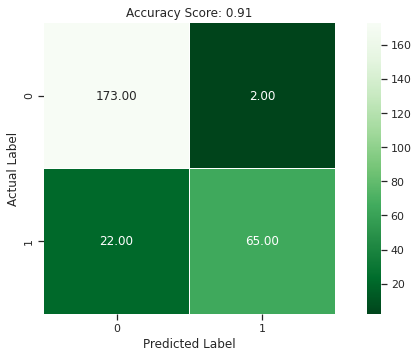

In [40]:
# creating confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred_out)

plt.figure(figsize = (10,5))
sns.heatmap(cm, annot = True, fmt = ".2f", linewidths = .5, square = True,  cmap = "Greens_r");
plt.ylabel("Actual Label");
plt.xlabel("Predicted Label");
plt.title("Accuracy Score: {:.2f}".format(round((cm[0, 0] + cm [1, 1]) / (np.sum(cm)),2)));

It performs better on a true holdout set which can happen occasionally.
Let's try a Gaussian Naive Bayes classifier now.
The majority of the steps are similar.

In [41]:
# features
X = titanic_data[["sex", "pclass", "embarked", "age", "sibsp", "parch", "fare"]]
print(X.shape)

# target
y = titanic_data["survived"]
print(y.shape)

(1309, 7)
(1309,)


In [42]:
# splitting the data using K-Folds Cross Validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, shuffle = True)
print("X_train:", len(X_train), "X_test:", len(X_test),
      "y_train:", len(X_train), "y_test:", len(X_test))

X_train: 1047 X_test: 262 y_train: 1047 y_test: 262


In [43]:
# creating an instance of Naive Bayessian classifier
gaussian_nb = GaussianNB()

In [44]:
# creating Simple Imputer, OneHot Encoder, and Standard Scaler objects
simple_imp = SimpleImputer(strategy = "median")
constant_imp = SimpleImputer(strategy = "most_frequent")
ohe = OneHotEncoder(handle_unknown = "ignore", sparse = False)
scaler = StandardScaler()

In [45]:
# creating pipeline for categorical variable transformations
imp_ohe = make_pipeline(constant_imp, ohe)

In [46]:
# creating pipeline for numerical variable transformations
imp_std = make_pipeline(simple_imp, scaler)

In [47]:
# transforming variables using a column transformer
ct_imputer = make_column_transformer(
    (imp_ohe, ["sex", "pclass", "embarked"]),
    (imp_std, ["age", "sibsp", "parch", "fare"])
)

In [48]:
# creating a pipeline
pipe = make_pipeline(ct_imputer, gaussian_nb)
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['sex', 'pclass',
                                                   'embarked']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                 

In [49]:
# specifying hypertuning parameters to use in a grid search
params = {} # none at the moment

In [50]:
# creating grid search CV instance
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, params, cv = 5, scoring = "accuracy")
grid.fit(X_train, y_train);

In [51]:
# displaying grid search results
results = pd.DataFrame(grid.cv_results_).sort_values("rank_test_score").reset_index(drop = True)[:10]
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.027879,0.01939,0.011752,0.006888,{},0.795238,0.809524,0.779904,0.746411,0.779904,0.782196,0.021014,1


In [52]:
# printing best score and parameters
print("best score:", round(grid.best_score_, 2), "\n", "best parameters:", grid.best_params_, sep = "\n")

best score:
0.78


best parameters:
{}


The mean test score is about 78%. It's barely lower on average than the logistic regression classifier.
Let's try some predictions on the true holdout set.

In [53]:
# predicting passenger outcome
pred_out = grid.predict(X_test)

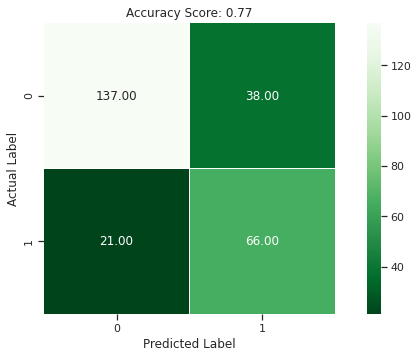

In [54]:
# creating confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred_out)

plt.figure(figsize = (10,5))
sns.heatmap(cm, annot = True, fmt = ".2f", linewidths = .5, square = True,  cmap = "Greens_r");
plt.ylabel("Actual Label");
plt.xlabel("Predicted Label");
plt.title("Accuracy Score: {:.2f}".format(round((cm[0, 0] + cm [1, 1]) / (np.sum(cm)),2)));

The accuracy on the true holdout set is about 77% so lower than the average on the cross validation sets of about 78%. It is important to note that I tried using features with insignificant correlation to the target variable. The reason is the violation of conditional independence between variables using the Naive Bayes classifier. In the end, the model performance is adequate considering we did not perform any parameter tuning for it.